In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, average_precision_score, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# CONSTANTS
DATA_PATH   = '../resources/model_datasets.npz'
GRID_PATH  = '../resources/model_results/logistic_regression_grid.npy'
MODEL_PATH  = '../resources/best_models/logistic_regression.npy'
TRAIN_MODEL = False

# Logistic Regression Model

### Load the data

In [3]:
# Extract the arrays from the NPZ file
with np.load(DATA_PATH, allow_pickle=True) as npz: 
    X_train = npz['X_train'] 
    X_test = npz['X_test']
    y_train = npz['y_train']
    y_test = npz['y_test']
    Ids_train = npz['Ids_train']
    Ids_test = npz['Ids_test']
    candidates = npz['candidates']
    candidate_ids = npz['candidate_ids']
    feature_names = npz['feature_names']
    label_names = npz['label_names']
    
# Check shapes
print('Training set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

# Label counts
pd.DataFrame({
    'count': pd.value_counts(y_train), 
    'normalized': pd.value_counts(y_train, normalize=True)}
)

Training set shape: (3000, 21) (3000,)
Test set shape: (898, 21) (898,)


,count,normalized
0,1761,0.587
1,1239,0.413


### Hyperparameters tuning

A logistic regression model is a probabilistic classifier that gives the probabilities than a test point belongs to one class or the other. A binary classifier could be built simply by fitting a linear regression. However, we would have to deal with negative and greater than one probabilities. So, instead of relating probabilities to a linear function in the features space, logistic regression use a logistic function (sigmoid curve), a strongly non-linear function that guarantee that the probabilities remains in the [0, 1] range. How this probabilistic function relates to the features ? In fact, by the way the logistic model is expressed, its logit/log-odds is linear in the feature space X. Who say linear regression, say that a vector of p+1 coefficients has to be learned where p is the number of features. It will be the job of the SGD algorithm to find these coefficients. 

The following hyperparameters will be tuned by grid search and 5-folds cross-validation:

* PCA number of components
* Regularizazion strength $\alpha$
* Regularization term: L1 and L2

Note that by reducing the number of dimensions with PCA, we also reduce the number of coefficients the model has to learn. The regularizazion strength allow us to manage the bias-variance trade-off: high alpha => high bias/low variance, low alpha => low bias/high variance.

Because the imbalance of our target variable, we apply weights inversely proportional to class frequencies: `class_weight='balanced'`.

In [4]:
# Hyperparameters
pca__n_components = [9, 12, 15, 18, None]
log__alpha = np.logspace(-10, -1, 100)
log__penalty = ['l1', 'l2']
   
# Train the model if required
if TRAIN_MODEL:
    
    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0)),
        ('log', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, class_weight='balanced', random_state=0))
    ])

    # Grid parameters
    grid = ParameterGrid({
        'pca__n_components': pca__n_components,
        'log__penalty': log__penalty,
        'log__alpha': log__alpha
    })
    
    # Scorers
    average_precision_scorer = make_scorer(average_precision_score, 
                                           greater_is_better=True, 
                                           needs_proba=False,
                                           needs_threshold=True)
    
    roc_auc_scorer = make_scorer(roc_auc_score, 
                                 greater_is_better=True, 
                                 needs_threshold=True)
    
    # Grid Search with cross-validation
    grid_cv = GridSearchCV(
        pipe,
        grid.param_grid,
        cv=5,  # 5 folds => 2400 training, 600 validation
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'roc_auc': roc_auc_scorer,
            'average_precision': average_precision_scorer
        },
        refit=False,
        verbose=3
    )

    # Fit the model
    grid_cv.fit(X_train, y_train)
    
    # Save results in a numpy file
    np.save(GRID_PATH, grid_cv)
else:
    # Load the grid search results from file
    grid_cv = np.load(GRID_PATH, allow_pickle=True).item(0)

### Model selection

We can extract the results and build a dataframe to analyze them:

In [5]:
# We want to tune our models according to the precision metric
score = 'precision'

# Generic variable names to easely change the metric
r = grid_cv.cv_results_
mean_train_score = 'mean_train_' + score
mean_valid_score = 'mean_test_' + score
std_train_score  = 'std_train_' + score
std_valid_score  = 'std_test_' + score

# Create a DataFrame to analyze the grid search results
df = pd.DataFrame.from_items([
    ('n_components', r['param_pca__n_components']),
    ('alpha', r['param_log__alpha']),
    ('penalty', r['param_log__penalty']),
    ('mean_train_score', r[mean_train_score]),
    ('mean_valid_score', r[mean_valid_score]),
    ('delta_score', np.abs(r[mean_train_score] - r[mean_valid_score])),
    ('std_train_score', r[std_train_score]),
    ('std_valid_score', r[std_valid_score])
])

# Replace the PCA None value by the number of features
df.n_components.fillna(X_train.shape[1], inplace=True)

print('Number of models:', df.shape[0])
df.head(5)

Number of models: 1000


,n_components,alpha,penalty,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
0,9,1e-10,l1,0.742534,0.749609,0.007075,0.020819,0.030072
1,12,1e-10,l1,0.716064,0.712027,0.004036,0.024410,0.039123
2,15,1e-10,l1,0.707761,0.706767,0.000994,0.044927,0.051037
3,18,1e-10,l1,0.735871,0.744928,0.009057,0.016274,0.033220
4,21,1e-10,l1,0.724324,0.717684,0.006640,0.058406,0.064243


The following scatter plots will give us better insight about the results :

* mean training score VS validation standard deviation
* mean validation score VS validation standard deviation
* delta mean scores VS validation standard deviation

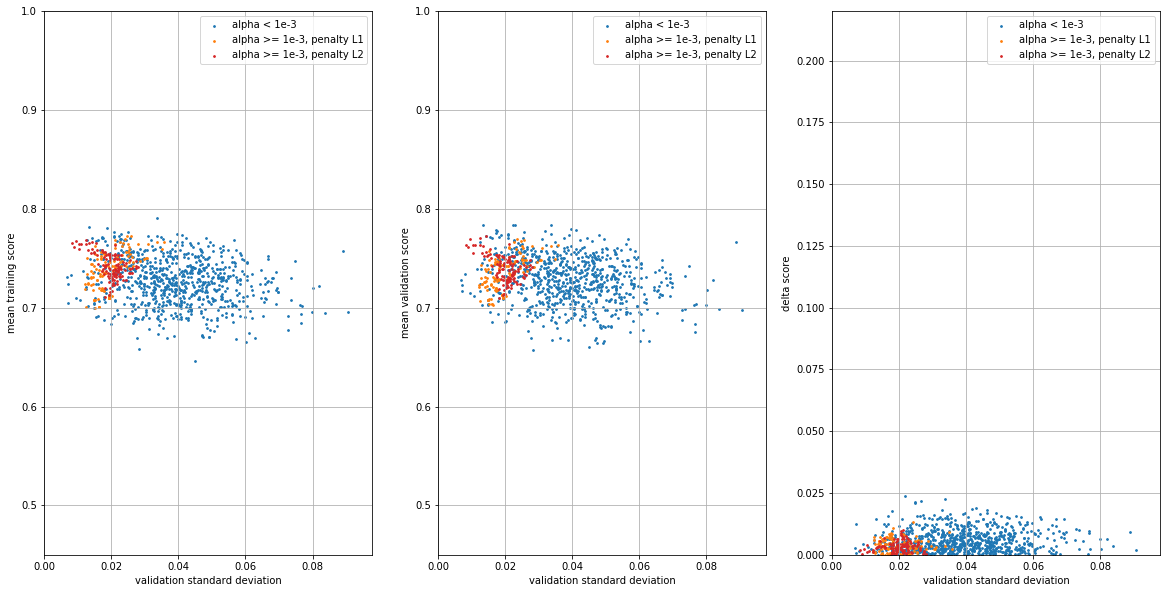

In [6]:
# Selection filters
filter_alpha = (df.alpha < 1e-3)
filter_penalty = (df.penalty == 'l1')

# Plot vars
ylabel = ['mean training score', 'mean validation score', 'delta score']
ylims = [(0.45, 1), (0.45, 1), (0, 0.22)]

i = 0
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
for var in ['mean_train_score', 'mean_valid_score', 'delta_score']:
    ax[i].scatter(df.std_valid_score[filter_alpha], df.loc[filter_alpha, var], color='C0', label='alpha < 1e-3', s=3)
    ax[i].scatter(df.std_valid_score[~filter_alpha & filter_penalty], df.loc[~filter_alpha & filter_penalty, var], color='C1', label='alpha >= 1e-3, penalty L1', s=3)
    ax[i].scatter(df.std_valid_score[~filter_alpha & ~filter_penalty], df.loc[~filter_alpha & ~filter_penalty, var], color='C3', label='alpha >= 1e-3, penalty L2', s=3)
    
    ax[i].grid(axis='both')
    ax[i].set(xlabel='validation standard deviation', ylabel=ylabel[i], xlim=(0, ax[i].get_xlim()[1]), ylim=ylims[i])
    ax[i].legend(loc='upper right')
    i += 1

plt.show()

There are models with a validation standard deviation below 1%. The models with higher regularization strength have less spreaded validation standard deviation range because they tend to have higher bias but lower variance. Given the fact that our problem isn't linear, the impact on the bias is less evident...

Given the results, our wish would be to find a model satisfying the following conditions:

* validation standard deviation <= 1%
* mean validation precision >= 75%

In [7]:
f_std_valid = (df.std_valid_score <= 0.01)
f_valid_score = (df.mean_valid_score > 0.75)

filter =  f_std_valid & f_valid_score
best_models = df[filter].sort_values(by='std_valid_score', ascending=True)
best_models

,n_components,alpha,penalty,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
808,18,0.00187382,l2,0.765121,0.763358,0.001763,0.017279,0.008312
819,21,0.00231013,l2,0.761534,0.761174,0.000360,0.010373,0.008861
809,21,0.00187382,l2,0.767529,0.769729,0.002199,0.016127,0.009454


The mean validation precision score being the same, selecting the model with the best validation standard deviation sounds indicated...

### Best model evaluation

We must now to train these model on the full training set and evaluate it on the test set :

In [8]:
# Best model hyperparameters
pca__n_components = best_models.n_components.values[0]
log__alpha = best_models.alpha.values[0]
log__penalty = best_models.penalty.values[0]

if TRAIN_MODEL:
    
    # Train the best model on the full training set
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca__n_components, random_state=0)),
        ('log', SGDClassifier(alpha=log__alpha,
                              penalty=log__penalty,
                              loss='log', 
                              max_iter=1000, 
                              tol=1e-3, 
                              class_weight='balanced', 
                              random_state=0))
    ])
    pipe.fit(X_train, y_train)
    
    # Save the model in a numpy file
    np.save(MODEL_PATH, pipe)
else:
    # Load the model from file
    pipe = np.load(MODEL_PATH, allow_pickle=True).item(0)

In [9]:
# Get the predictions 
y_pred_tr = pipe.predict(X_train)
y_pred_te = pipe.predict(X_test)

# Get the contingency matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_te).ravel()

# Print the results
print('Evaluation of the best model on the test set:')
print('---------------------------------------------')
print('Logistic Regression Precision (training set): ', np.round(precision_score(y_train, y_pred_tr), 3))
print('Logistic Regression Precision (test set) : ', np.round(precision_score(y_test, y_pred_te), 3))
print('\n')
print('Confusion Matrix (test set):')
print('----------------------------\n')
print('                Actual N\tActual P\nPredicted N\t{:3d} (TN)\t{:3d} (FN)\nPredicted P\t{:3d} (FP)\t{:3d} (TP)'.format(tn, fn, fp, tp))
print('\n')
print('Metric Summary (test set):')
print('-------------------------- ')
print('Precision : ', np.round(precision_score(y_test, y_pred_te), 3))
print('Recall    : ', np.round(recall_score(y_test, y_pred_te), 3))
print('Accuracy  : ', np.round(accuracy_score(y_test, y_pred_te), 3))
print('F1 Score  : ', np.round(f1_score(y_test, y_pred_te), 3))

Evaluation of the best model on the test set:
---------------------------------------------
Logistic Regression Precision (training set):  0.773
Logistic Regression Precision (test set) :  0.811


Confusion Matrix (test set):
----------------------------

                Actual N	Actual P
Predicted N	449 (TN)	 36 (FN)
Predicted P	 78 (FP)	335 (TP)


Metric Summary (test set):
-------------------------- 
Precision :  0.811
Recall    :  0.903
Accuracy  :  0.873
F1 Score  :  0.855


Again, the test precision score is clearly better than predicted by cross-validation. The test dataset doesn't have a lot of samples, hence the observed test score variance.

The test precision score is better than the baseline models but worse than the other kind of models. However, it does a good job to identify most of the exoplanets with a recall at 90%.